In [20]:
import s3fs
s3 = s3fs.S3FileSystem(anon=False)
from math import cos, asin, sqrt
import re

import numpy as np
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import os
import rioxarray as rio
import xarray as xr
import rasterio
import glob
from geocube.api.core import make_geocube
from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
import warnings
import folium
import datetime
import time
from folium import plugins
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

import sys
sys.path.insert(0, '/projects/old_shared/fire_weather_vis/base-fwi-vis/')
import fwiVis.fwiVis as fv

In [21]:
neon = gpd.read_file("/projects/old_shared/fire_weather_vis/ref_data/NEON_DOMAIN/NEON_Domains.shp")


In [3]:
### Get all IDs

# flist = os.listdir("/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/") ### why is this changing every time? 


# import re

# file_ids = [re.sub("([^a-zA-Z0-9].*)$", "", x) for x in flist]
# file_ids = [re.sub("F", "", x) for x in file_ids]

# ids = file_ids
# file_ids = set(file_ids)

In [6]:
#list(file_ids)[0]

In [137]:
#i = list(file_ids)[0]

files = s3.ls("s3://veda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/") # This will update through time. Not nessisary now because focus on 2019
st_id_map = pd.read_csv("/projects/my-public-bucket/fire_weather_vis/ref_data/isd-history.csv") ## For mappting ID's to lat lon

# Helper Variable
stations = fv.st_avail(files, st_id_map = st_id_map)
st_dict = stations[['Lat', 'Lon']].to_dict('records')

i = '11446'

year = "2020"

region = "WesternUS_REDO"

def station_spread(st_id_map, st_dict, files, i, year, region):

    try:
        raw_fire = fv.load_large_fire(i, year = year, path_region= region)
        raw_fire["fireID"] = str(i)
        full = fv.get_gpm_spread(raw_fire)
    except Exception as e:
        print("Error at imerge_merge with Fire: ",i,)
        bad_log = traceback.format_exc(limit = 40) # Get log of error
        print(bad_log)
        bad_ids.append(
        {
            "fireID": i, 
            "func_failed": "imerge_merge",
            "log": bad_log
        }
        )

    ### Find the closest station

    foi = full
    foi = foi.rename(columns = {"lat": "Lat", "lon": "Lon"})
    foi = foi.iloc[0] # First element

    stations = fv.st_avail(files, st_id_map = st_id_map)
    #stations = fv.closest_srch(st_dict, foi)
    all_st_search = fv.all_stations_search(st_dict = st_dict, fire_center = foi, id_key = st_id_map)

    final_perimeter = full[full.t == max(full.t)]
    #print(final_perimeter.envelope.exterior.coords.xy)
    #lons = final_perimeter.envelope.exterior.coords.xy[0]
    #lats = final_perimeter.envelope.exterior.coords.xy[1]


    ### Find the neon region the fire is in. 

    regions = gpd.overlay(neon, final_perimeter, how = "intersection")
    regions = neon[neon.DomainID.isin(regions.DomainID)]
    #print(regions)

    ## get subset of stations that are close to the fire

    sub_search = all_st_search[all_st_search.Dist_to_fire < 150]
    sub_search = gpd.GeoDataFrame(sub_search, geometry=gpd.points_from_xy(sub_search.Lon, sub_search.Lat))

    if(len(sub_search) > 0):
        ## Check if in any of the intersecting regions
        sts = gpd.overlay(sub_search.set_crs("epsg:4326"), regions.to_crs("epsg:4326"), how = 'intersection')
        fire_min = min(full.t)
        fire_max = max(full.t)

        ### Check if overlapping time range
        sts.BEGIN = pd.to_datetime(sts['BEGIN'], format='%Y%m%d')
        sts.END = pd.to_datetime(sts['END'], format='%Y%m%d')

        sts = sts[sts.END >= fire_max]
        sts = sts[sts.BEGIN <= fire_min]
        #print(sts)
        if(len(sts) > 0):
            ## Optionally merge
            sts = sts[sts.Dist_to_fire == min(sts.Dist_to_fire)] ## Get closest station
            #st = fv.get_st(lat = sts.Lat, lon = sts.Lon, stations = stations)
            #print(sts)
            st = stations.loc[(stations.Lat == sts.Lat[0]) & (stations.Lon == sts.Lon[0])]
            dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
            dat = fv.date_convert(dat)
            full['st_ID'] = str(sts.USAF[0]) + "_" + str(sts.WBAN[0])
            full['st_dist_to_fire'] = str(sts.Dist_to_fire.unique())
            #full_m = fv.fr_st_merge(full, dat,  sub_type = "month_before")
            full_m = fv.fr_st_merge(full, dat)
            full_m["fireID"] = str(full_m.fireID[0])
            return(full_m)

        ## Optionally write out a cheat-sheet
        
        
# def station_spread2(st_id_map, st_dict, files, i, year, region):


#     full = fv.load_large_fire(i, year = year, path_region= region)
#     full["fireID"] = str(i)


#     ### Find the closest station

#     foi = full
#     foi = foi.rename(columns = {"lat": "Lat", "lon": "Lon"})
#     foi = foi.iloc[0] # First element

#     stations = fv.st_avail(files, st_id_map = st_id_map)
#     #stations = fv.closest_srch(st_dict, foi)
#     all_st_search = fv.all_stations_search(st_dict = st_dict, fire_center = foi, id_key = st_id_map)

#     final_perimeter = full[full.t == max(full.t)]
#     #print(final_perimeter.envelope.exterior.coords.xy)
#     #lons = final_perimeter.envelope.exterior.coords.xy[0]
#     #lats = final_perimeter.envelope.exterior.coords.xy[1]


#     ### Find the neon region the fire is in. 

#     regions = gpd.overlay(neon, final_perimeter, how = "intersection")
#     regions = neon[neon.DomainID.isin(regions.DomainID)]
#     #print(regions)

#     ## get subset of stations that are close to the fire

#     sub_search = all_st_search[all_st_search.Dist_to_fire < 150]
#     sub_search = gpd.GeoDataFrame(sub_search, geometry=gpd.points_from_xy(sub_search.Lon, sub_search.Lat))

#     if(len(sub_search) > 0):
#         ## Check if in any of the intersecting regions
#         sts = gpd.overlay(sub_search.set_crs("epsg:4326"), regions.to_crs("epsg:4326"), how = 'intersection')
#         fire_min = min(full.t)
#         fire_max = max(full.t)

#         ### Check if overlapping time range
#         sts.BEGIN = pd.to_datetime(sts['BEGIN'], format='%Y%m%d')
#         sts.END = pd.to_datetime(sts['END'], format='%Y%m%d')

#         sts = sts[sts.END >= fire_max]
#         sts = sts[sts.BEGIN <= fire_min]
#         #print(sts)
#         if(len(sts) > 0):
#             ## Optionally merge
#             sts = sts[sts.Dist_to_fire == min(sts.Dist_to_fire)] ## Get closest station
#             #st = fv.get_st(lat = sts.Lat, lon = sts.Lon, stations = stations)
#             print(sts)
#             st = stations.loc[(stations.Lat == sts.Lat[0]) & (stations.Lon == sts.Lon[0])]
#             dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
#             dat = fv.date_convert(dat)
#             full['st_ID'] = str(sts.USAF[0]) + "_" + str(sts.WBAN[0])
#             full['st_dist_to_fire'] = str(sts.Dist_to_fire.unique())
#             full_m = fv.fr_st_merge(full, dat,  sub_type = "month_before")
#             full_m["fireID"] = str(full_m.fireID[0])
    
#             total = fv.get_gpm_spread(full_m)
#             return(total)

#         ## Optionally write out a cheat-sheet

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/


In [84]:
def get_spread_period(full_fr, time_of_interest = 12,  hours_before = 0, lags = [-2,-4,-12,-24,-48]):
    
    lables = ["Night", "Day"]
    for i in lables:

        times = full_fr["t"].loc[full_fr["spread_line" + i] == True] ## Is this acurate given the definitions above? 
        times_not = full_fr["t"].loc[full_fr["spread_line" + i] == False]
        #times_not = times_not[(times_not.dt.hour == 13) & (times_not.dt.minute == 30)]

        full_fr["spread_period"+ i] = np.nan

        for t in times:
            times_start = t - np.timedelta64((time_of_interest + hours_before), "h")
            times_end = t - np.timedelta64((hours_before), "h")
            full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True


        for l in times_not:
            times_start = l - np.timedelta64((time_of_interest + hours_before), "h")
            times_end = l - np.timedelta64((hours_before), "h")
            full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = False

        for lag in lags:
            full_fr["spread_period"+ i +"_lag_" + str(lag)] = full_fr["spread_period"+ i].shift(lag)

    return(full_fr)

In [121]:
files = s3.ls("s3://veda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/") # This will update through time. Not nessisary now because focus on 2019
st_id_map = pd.read_csv("/projects/my-public-bucket/fire_weather_vis/ref_data/isd-history.csv") ## For mappting ID's to lat lon

# Helper Variable
stations = fv.st_avail(files, st_id_map = st_id_map)
st_dict = stations[['Lat', 'Lon']].to_dict('records')

#i = '11446'
i = '11440'

year = "2020"

region = "WesternUS_REDO"


full = station_spread(st_id_map = st_id_map, st_dict = st_dict, files = files, i = i, year = year, region = region)
full = get_spread_period(full)

full

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11440_20200819AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11440_20200819PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11440_20200820AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11440_20200820PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11440_20200821AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11440_20200821PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11440_20200822AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F11440_2

/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:570: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:571: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/old_shared/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:865: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "

Searching for availible stations atveda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/
      Lat      Lon  Dist_to_fire    USAF   WBAN          STATION NAME CTRY  \
0  44.905 -123.001     109.63066  726940  24232  MCNARY FIELD AIRPORT   US   

  STATE  ICAO  ELEV(M)      BEGIN        END  OBJECTID  Shape_Leng  DomainID  \
0    OR  KSLE     63.4 1973-01-01 2022-09-26        87  204.654121        16   

          DomainName  Shape_Le_1  Shape_Area                     geometry  
0  Pacific Northwest  204.654121   47.721775  POINT (-123.00100 44.90500)  


/tmp/ipykernel_940/2793441969.py:80: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
/tmp/ipykernel_940/2695966448.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True
/tmp/ipykernel_940/2695966448.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True
/projects/myenvs/fireatlas_oct4/lib

,n_pixels,n_newpixels,farea,fperim,flinelen,duration,pixden,meanFRP,t,geometry,...,spread_periodNight_lag_-4,spread_periodNight_lag_-12,spread_periodNight_lag_-24,spread_periodNight_lag_-48,spread_periodDay,spread_periodDay_lag_-2,spread_periodDay_lag_-4,spread_periodDay_lag_-12,spread_periodDay_lag_-24,spread_periodDay_lag_-48
0,3.0,3.0,0.350845,2.460630,2.460630,0.0,8.550796,4.906667,2020-08-17 00:00:00,"POLYGON ((-121.61868 44.77358, -121.62264 44.7...",...,False,False,False,True,NaN,False,False,False,False,True
1,7.0,4.0,0.664165,2.993279,2.993279,0.5,10.539544,22.850000,2020-08-17 12:00:00,"POLYGON ((-121.62894 44.77507, -121.62896 44.7...",...,False,False,False,True,NaN,False,False,False,False,True
2,11.0,4.0,1.046994,3.818821,3.818821,1.0,10.506264,2.952500,2020-08-18 00:00:00,"POLYGON ((-121.61662 44.77627, -121.61660 44.7...",...,False,False,False,True,False,False,False,False,False,True
3,13.0,2.0,1.440004,4.803699,1.772765,1.5,9.027752,8.020000,2020-08-18 12:00:00,"POLYGON ((-121.62005 44.76853, -121.62008 44.7...",...,True,False,False,True,False,False,False,False,False,True
4,57.0,44.0,8.546287,12.253317,11.613147,2.0,6.669563,4.708182,2020-08-19 00:00:00,"POLYGON ((-121.62065 44.76829, -121.62067 44.7...",...,True,False,False,True,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-29 07:00:00,None,...,NaN,None,None,None,False,False,False,None,None,None
1761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-29 08:00:00,None,...,NaN,None,None,None,False,False,None,None,None,None
1762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-29 09:00:00,None,...,NaN,None,None,None,False,False,None,None,None,None
1763,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-29 10:00:00,None,...,NaN,None,None,None,False,None,None,None,None,None


In [155]:
full.columns

Index(['n_pixels', 'n_newpixels', 'farea', 'fperim', 'flinelen', 'duration',
       'pixden', 'meanFRP', 't', 'geometry', 'lon', 'lat', 'fireID',
       'fline_diff', 'farea_diff', 'spread_line', 'spread_lineNight',
       'spread_lineDay', 'spread_day', 'st_ID', 'st_dist_to_fire', 'YYYY',
       'MM', 'DD', 'HH', 'TEMP_C', 'RH_PERC', ' VPD_HPA', 'WDSPD_KPH',
       'PREC_MM', 'SNOWD_M', 'FFMC', 'DMC', 'DC', 'BUI', 'ISI', 'FWI',
       'OBSMINUTEDIFFTEMP', 'OBSMINUTEDIFFRH', 'OBSMINUTEDIFFWDSPD',
       'OBSMINUTEDIFFPREC', 'OBSMINUTEDIFFSNOW', 'HH_format',
       'spread_periodNight', 'spread_periodNight_lag_-2',
       'spread_periodNight_lag_-4', 'spread_periodNight_lag_-12',
       'spread_periodNight_lag_-24', 'spread_periodNight_lag_-48',
       'spread_periodDay', 'spread_periodDay_lag_-2',
       'spread_periodDay_lag_-4', 'spread_periodDay_lag_-12',
       'spread_periodDay_lag_-24', 'spread_periodDay_lag_-48'],
      dtype='object')

In [163]:
#full = full.sort_values(by = ["t"])
pd.set_option('display.min_rows', 5000)
#pd.reset_option('display.max_rows')
full[["fireID", "t", "farea", "FWI", "spread_lineNight", "spread_periodNight", 'spread_periodNight_lag_-4']].head(50)


,fireID,t,farea,FWI,spread_lineNight,spread_periodNight,spread_periodNight_lag_-4
0,11440,2020-08-17 00:00:00,0.350845,23.630,2,NaN,False
148,11440,2020-08-17 01:00:00,NaN,23.427,NaN,NaN,NaN
149,11440,2020-08-17 02:00:00,NaN,28.564,NaN,NaN,NaN
150,11440,2020-08-17 03:00:00,NaN,21.266,NaN,NaN,NaN
151,11440,2020-08-17 04:00:00,NaN,20.721,NaN,NaN,NaN
152,11440,2020-08-17 05:00:00,NaN,19.952,NaN,NaN,NaN
153,11440,2020-08-17 06:00:00,NaN,19.508,NaN,NaN,NaN
154,11440,2020-08-17 07:00:00,NaN,23.896,NaN,NaN,NaN
155,11440,2020-08-17 08:00:00,NaN,17.909,NaN,NaN,False
156,11440,2020-08-17 09:00:00,NaN,18.101,NaN,NaN,False


(array([18489., 18506., 18520., 18536., 18550., 18567.]),
 [Text(18489.0, 0, '2020-08-15'),
  Text(18506.0, 0, '2020-09-01'),
  Text(18520.0, 0, '2020-09-15'),
  Text(18536.0, 0, '2020-10-01'),
  Text(18550.0, 0, '2020-10-15'),
  Text(18567.0, 0, '2020-11-01')])

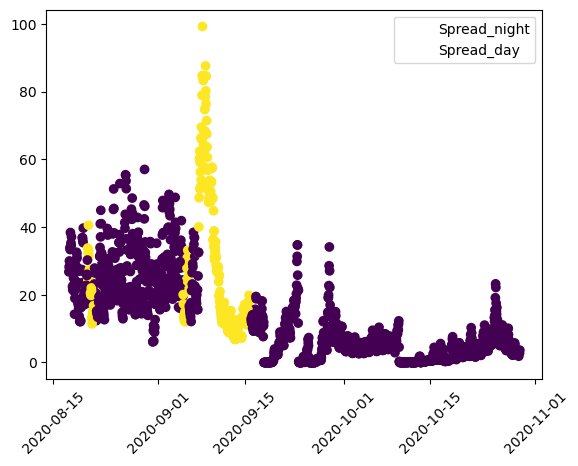

In [143]:


full = full.sort_values(by = ["t"])

plt.scatter(full.t.astype('datetime64[ns]'), full.FWI, c = full["spread_periodNight"], label = "Spread_night")
plt.scatter(full.t.astype('datetime64[ns]'), full.FWI, c = full["spread_periodDay"], label = "Spread_day")
plt.legend()
plt.xticks(rotation = 45)

(array([18489., 18506., 18520., 18536., 18550., 18567.]),
 [Text(18489.0, 0, '2020-08-15'),
  Text(18506.0, 0, '2020-09-01'),
  Text(18520.0, 0, '2020-09-15'),
  Text(18536.0, 0, '2020-10-01'),
  Text(18550.0, 0, '2020-10-15'),
  Text(18567.0, 0, '2020-11-01')])

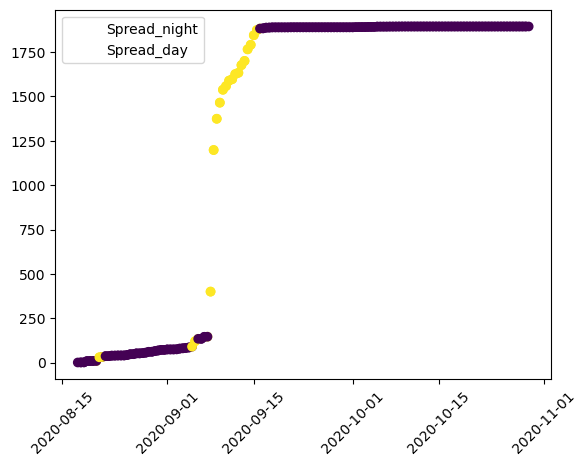

In [129]:
full = full.sort_values(by = ["t"])

plt.scatter(full.t.astype('datetime64[ns]'), full.farea, c = full["spread_periodNight"], label = "Spread_night")
plt.scatter(full.t.astype('datetime64[ns]'), full.farea, c = full["spread_periodDay"], label = "Spread_day")
plt.legend()
plt.xticks(rotation = 45)